In [1]:
#data format library
import h5py
#numpy
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
# %matplotlib notebook
from sklearn.cluster import KMeans

import sys
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as colors
import os
from scipy.integrate import odeint
#change path to where 'manuscript_data' is saved
dir_path = '/home/antonio/Repositories/manuscript_data/'
sys.path.append(dir_path+'/code/utils/')
import operator_calculations as op_calc
import worm_dynamics as worm_dyn
import stats
from sklearn.linear_model import LinearRegression
colors_state_=plt.rcParams['axes.prop_cycle'].by_key()['color'][:10]

In [2]:
mat=h5py.File(dir_path+'Foraging/ForagingData/PNAS2011-DataStitched.mat','r')

refs=list(mat['#refs#'].keys())[1:]
tseries_w=[ma.masked_invalid(np.array(mat['#refs#'][ref]).T)[:,:5] for ref in refs]
mat.close()
frameRate=16.
dt=1/frameRate

masked_ts_w = []
for worm in np.arange(len(tseries_w)):
    ts_w = tseries_w[worm]
    ts_w[0] = ma.masked
    ts_w[-1] = ma.masked
    masked_ts_w.append(ts_w)

import worm_dynamics as worm_dyn
segments=op_calc.segment_maskedArray(ma.vstack(masked_ts_w),5)
omegas_all=ma.zeros(ma.vstack(masked_ts_w).shape[0])
a3s_all=ma.zeros(ma.vstack(masked_ts_w).shape[0])
for t0,tf in segments:
    phi,omega,a3=worm_dyn.compute_phi_omega_a3(ma.vstack(masked_ts_w),t0,tf)
    omegas_all[t0:tf] = omega
    a3s_all[t0:tf] = a3
omegas_all[omegas_all==0]=ma.masked
a3s_all[a3s_all==0]=ma.masked

In [3]:
import scipy.io
mat = scipy.io.loadmat(dir_path+'Foraging/ForagingData/wormCentroid.mat')
X_worm,Y_worm = mat['cmX'],mat['cmY']

centroids_w = []
for kw in range(X_worm.shape[0]):
    centroids_w.append(np.vstack([X_worm[kw,::2],Y_worm[kw,::2]]).T)
    
all_centroids = ma.vstack(centroids_w)

from scipy.signal import savgol_filter, general_gaussian

window_length=33
poly_order = 3
deriv = 0
delta = 1/frameRate

X_w = []
for X in centroids_w:
    X_smooth = savgol_filter(X, window_length=window_length, polyorder=poly_order, deriv=deriv, delta=delta,axis=0)
    X_smooth = ma.masked_invalid(X_smooth)
    X_smooth[0] = ma.masked
    X_smooth[-1] = ma.masked
    X_w.append(X_smooth)
    
centroids_smooth = ma.vstack(X_w)

In [4]:
def py_ang(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'    """
    if ma.count_masked(ma.vstack((v1,v2)))>0:
        return np.nan
    cosang = np.dot(v1, v2)
    sinang = np.linalg.norm(np.cross(v1, v2))
    angle = np.arctan2(sinang, cosang)
    if angle>np.pi/2:
        angle = np.pi-angle
    return angle

def get_raw_angles(centroids):
    vec1 = centroids[2:]-centroids[1:-1]
    vec2 = centroids[:-2]-centroids[1:-1]
    raw_angles = ma.zeros(centroids.shape[0])
    raw_angles[1:-1] = 180*ma.masked_invalid([py_ang(vec1[kt],vec2[kt]) for kt in range(len(vec1))])/np.pi
    raw_angles[0] = ma.masked
    raw_angles[-1] = ma.masked
    return raw_angles

def get_raw_speeds(centroids):
    raw_speed = ma.zeros(len(centroids))
    raw_speed[1:] = ma.sqrt((ma.diff(centroids,axis=0)**2).sum(axis=1))
    raw_speed[0] = ma.masked
    return raw_speed

speed = get_raw_speeds(centroids_smooth)/dt
angles = get_raw_angles(centroids_smooth)
curvature = angles/(dt)

In [5]:
n_clusters=1000
f = h5py.File(dir_path+'Foraging/symbol_sequences/labels_{}_clusters.h5'.format(n_clusters))
labels_traj = ma.array(f['labels_traj'],dtype=int)
mask_traj = np.array(f['mask_traj'],dtype=bool)
labels_phspace = ma.array(f['labels_phspace'],dtype=int)
mask_phspace = np.array(f['mask_phspace'],dtype=bool)
centers_phspace = np.array(f['centers_phspace'])
centers_traj = np.array(f['centers_traj'])
f.close()

labels_traj[mask_traj] = ma.masked
labels_phspace[mask_phspace] = ma.masked

12


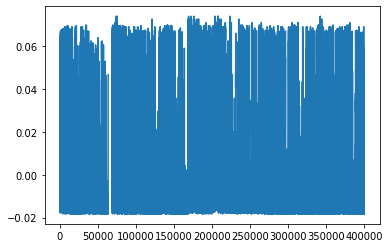

In [6]:
delay = int(.75*frameRate)
print(delay)
# delay=13
lcs,P = op_calc.transition_matrix(labels_traj,delay,return_connected=True)
final_labels = op_calc.get_connected_labels(labels_traj,lcs)
n_modes=10
inv_measure = op_calc.stationary_distribution(P)
R = op_calc.get_reversible_transition_matrix(P)
eigvals,eigvecs = op_calc.sorted_spectrum(R,k=n_modes)
sorted_indices = np.argsort(eigvals.real)[::-1]
eigvals = eigvals[sorted_indices][1:].real
eigvals[np.abs(eigvals-1)<1e-12] = np.nan
eigvals[eigvals<1e-12] = np.nan
t_imp =  -(delay*dt)/np.log(eigvals)

eigfunctions = eigvecs.real/np.linalg.norm(eigvecs.real,axis=0)
eigfunctions_traj = ma.array(eigfunctions)[final_labels,:]
eigfunctions_traj[final_labels.mask] = ma.masked

phi2 = eigfunctions[:,1]
plt.plot(eigfunctions_traj[:,1])
plt.show()

2


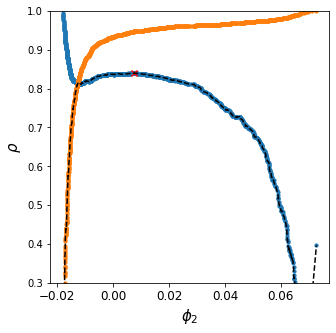

1
1 [0.9058013610201572, 0.7152434371969076] [0.24603384630523925, 0.7539661536947606]
3


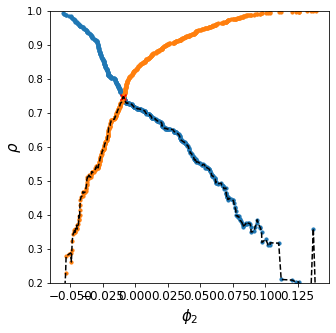

2
2 [0.9058013610201544, 0.7883942955089336, 0.6396220993332432] [0.24603384630523925, 0.3650905346776207, 0.38887561901713996]
4


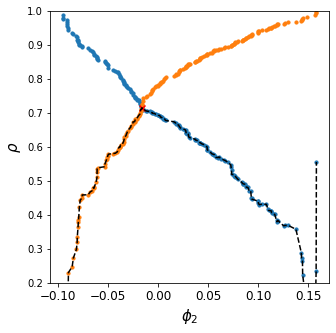

3
1 [0.9058013610201552, 0.7883942955089343, 0.7184722201985208, 0.5823284967763405] [0.24603384630523925, 0.3650905346776207, 0.21029300686454677, 0.17858261215259313]
5


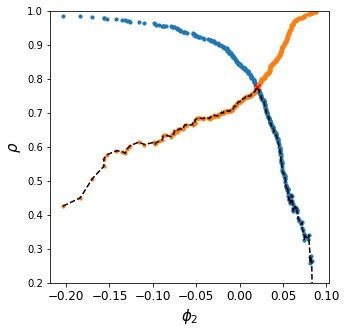

4
0 [0.9058013610201553, 0.7184722201985216, 0.5823284967763384, 0.7036651915010932, 0.7342887462468051] [0.24603384630523925, 0.21029300686454677, 0.17858261215259313, 0.21917068978572238, 0.1459198448918983]
6


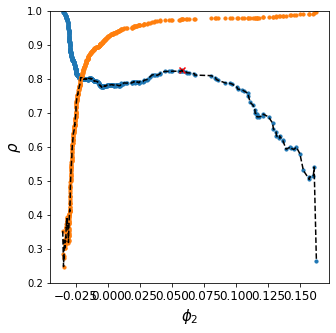

5
5 [0.7184722201985204, 0.5823284967763419, 0.7036651915010956, 0.734288746246804, 0.8516908473506538, 0.7609160440695097] [0.21029300686454677, 0.17858261215259313, 0.21917068978572238, 0.1459198448918983, 0.019472852572137045, 0.2265609937331022]
8


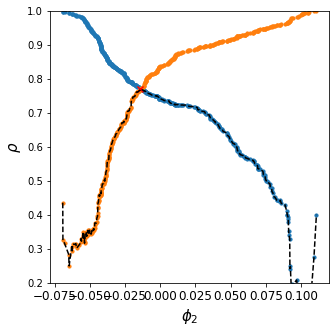

In [7]:
n_final_states=6
labels_tree = op_calc.recursive_partitioning_optimal(final_labels,delay,phi2,inv_measure,R,n_final_states,plot=True)

In [8]:
n_states = 5
kmeans_labels = labels_tree[n_states-2,:]
cluster_traj = ma.copy(final_labels)
cluster_traj[~final_labels.mask] = ma.array(kmeans_labels)[final_labels[~final_labels.mask]]
cluster_traj[final_labels.mask] = ma.masked


data_lifetimes = stats.state_lifetime(cluster_traj[::delay],delay*dt)

In [6]:
worms = np.arange(len(tseries_w))
len_w = len(tseries_w[0])
ensemble_labels_w=[]
for worm in worms:
    ensemble_labels_w.append(labels_traj[len_w*worm:len_w*(worm+1)])

In [7]:
sims_w = []
f = h5py.File(dir_path+'Foraging/ForagingData/symbol_sequence_simulations.h5','r')
for worm in worms:
    sims = np.array(f['{}/sims'.format(worm)],dtype=int)
    sims_w.append(sims)
f.close()

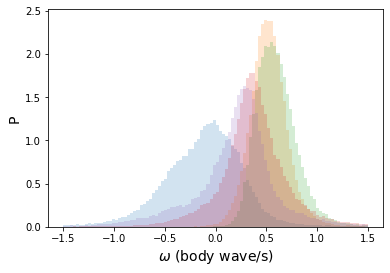

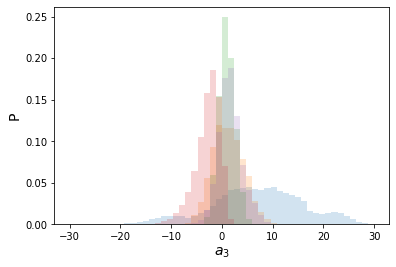

In [11]:
for state_idx in range(n_states):
    plt.hist(omegas_all[cluster_traj==state_idx].compressed(),bins=100,range=[-1.5,1.5],alpha=.2,density=True)
plt.xlabel('$\omega$ (body wave/s)',fontsize=14)
plt.ylabel('P',fontsize=14)
plt.show()
for state_idx in range(n_states):
    plt.hist(a3s_all[cluster_traj==state_idx].compressed(),bins=50,range=[-30,30],alpha=.2,density=True)
plt.xlabel('$a_3$',fontsize=14)
plt.ylabel('P',fontsize=14)
plt.show()

In [12]:
curvature_w = [curvature[len_w*kw:len_w*(kw+1)] for kw in worms]
speed_w = [speed[len_w*kw:len_w*(kw+1)] for kw in worms]

cluster_traj_w = [cluster_traj[len_w*kw:len_w*(kw+1)] for kw in worms]

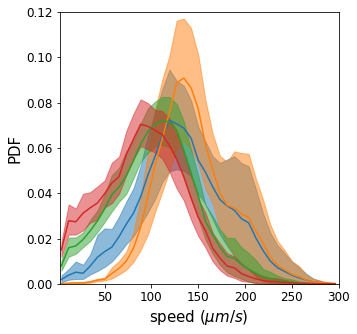

In [13]:
plt.figure(figsize=(5,5))
bins = np.linspace(0, 300,40)
db = bins[1]-bins[0]
centers = (bins[:-1]+bins[1:])/2
for ks in range(1,3):
    pd_w = []
    for kw in worms:
        pd = np.histogram(speed_w[kw][cluster_traj_w[kw]==ks], bins)[0]
        pd = pd/np.trapz(pd)
        pd_w.append(pd)
    mean,cil,ciu = stats.bootstrap(pd_w,n_times=5000)
    plt.plot(centers, mean, ms=4,c=colors_state_[ks-1])
    plt.fill_between(centers,cil,ciu,alpha=.5,color =colors_state_[ks-1])
plt.xlim(0,300)
plt.ylim(0,0.12)


for ks in range(3,5):
    pd_w = []
    for kw in worms:
        pd = np.histogram(speed_w[kw][cluster_traj_w[kw]==ks], bins)[0]
        pd = pd/np.trapz(pd)
        pd_w.append(pd)
    mean,cil,ciu = stats.bootstrap(pd_w,n_times=5000)
    plt.plot(centers, mean, ms=4,c = colors_state_[ks-1])
    plt.fill_between(centers,cil,ciu,alpha=.5,color = colors_state_[ks-1])
plt.xlim(2,300)
plt.xlabel(r'speed ($\mu m /s$)',fontsize=15)
plt.ylabel('PDF',fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# plt.savefig('speed_all_run_stats.pdf')
plt.show()

In [14]:
mask = cluster_traj==1
segments = np.where(np.abs(np.diff(np.concatenate([[False], mask, [False]]))))[0].reshape(-1, 2)
segments = segments[np.hstack(np.diff(segments,axis=1))>=frameRate/2]
sum_curv_fast1 = []
mean_speed_fast1 = []

thresh = np.percentile(angles.compressed(),90)
worm_indices_fast1 = []
for t_0,t_f in segments:
    c_ = angles[t_0:t_f]
    if np.any(c_<thresh):
        sum_curv_fast1.append(c_[c_<thresh].sum())
        mean_speed_fast1.append(speed[t_0:t_f].mean())
        worm_indices_fast1.append(int(np.floor(t_0/len_w)))
    
mask = cluster_traj==2
segments = np.where(np.abs(np.diff(np.concatenate([[False], mask, [False]]))))[0].reshape(-1, 2)
segments = segments[np.hstack(np.diff(segments,axis=1))>=frameRate/2]
sum_curv_fast2 = []
mean_speed_fast2 = []
worm_indices_fast2 = []
for t_0,t_f in segments:
    c_ = angles[t_0:t_f]
    if np.any(c_<thresh):
        sum_curv_fast2.append(c_[c_<thresh].sum())
        mean_speed_fast2.append(speed[t_0:t_f].mean())
        worm_indices_fast2.append(int(np.floor(t_0/len_w)))

    
mask = cluster_traj==3
segments = np.where(np.abs(np.diff(np.concatenate([[False], mask, [False]]))))[0].reshape(-1, 2)
segments = segments[np.hstack(np.diff(segments,axis=1))>=frameRate/2]
sum_curv_slow1 = []
mean_speed_slow1 = []
worm_indices_slow1 = []
for t_0,t_f in segments:
    c_ = angles[t_0:t_f]
    if np.any(c_<thresh):
        sum_curv_slow1.append(c_[c_<thresh].sum())
        mean_speed_slow1.append(speed[t_0:t_f].mean())
        worm_indices_slow1.append(int(np.floor(t_0/len_w)))

    
mask = cluster_traj==4
segments = np.where(np.abs(np.diff(np.concatenate([[False], mask, [False]]))))[0].reshape(-1, 2)
segments = segments[np.hstack(np.diff(segments,axis=1))>=frameRate/2]
sum_curv_slow2 = []
mean_speed_slow2 = []
worm_indices_slow2 = []
for t_0,t_f in segments:
    c_ = angles[t_0:t_f]
    if np.any(c_<thresh):
        sum_curv_slow2.append(c_[c_<thresh].sum())
        mean_speed_slow2.append(speed[t_0:t_f].mean())
        worm_indices_slow2.append(int(np.floor(t_0/len_w)))


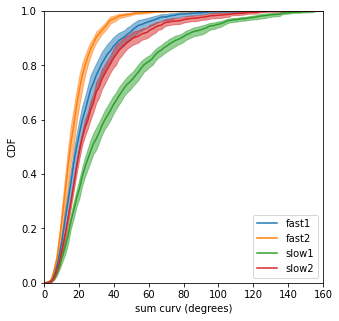

In [15]:
plt.figure(figsize=(5,5))
all_sum_curv_fast1 = np.hstack(sum_curv_fast1)
all_worm_indices_fast1 = np.hstack(worm_indices_fast1)

bins = np.linspace(0, 160,100)
db = bins[1]-bins[0]
centers = (bins[:-1]+bins[1:])/2
pd_w = []
for kw in worms:
    pd = np.histogram(all_sum_curv_fast1[all_worm_indices_fast1==kw], bins)[0]
    pd = pd/np.trapz(pd)
    pd_w.append(pd)
    
mean,cil,ciu = stats.bootstrap(np.cumsum(pd_w,axis=1),n_times=5000)
plt.plot(centers, mean, ms=4,c = colors_state_[0],label='fast1')
plt.fill_between(centers,cil,ciu,alpha=.5,color = colors_state_[0])

all_sum_curv_fast2 = np.hstack(sum_curv_fast2)
all_worm_indices_fast2 = np.hstack(worm_indices_fast2)

pd_w = []
for kw in worms:
    pd = np.histogram(all_sum_curv_fast2[all_worm_indices_fast2==kw], bins)[0]
    pd = pd/np.trapz(pd)
    pd_w.append(pd)
mean,cil,ciu = stats.bootstrap(np.cumsum(pd_w,axis=1),n_times=5000)
plt.plot(centers, mean, ms=4,c = colors_state_[1],label='fast2')
plt.fill_between(centers,cil,ciu,alpha=.5,color = colors_state_[1])

all_sum_curv_slow1 = np.hstack(sum_curv_slow1)
all_worm_indices_slow1 = np.hstack(worm_indices_slow1)

pd_w = []
for kw in worms:
    pd = np.histogram(all_sum_curv_slow1[all_worm_indices_slow1==kw], bins)[0]
    pd = pd/np.trapz(pd)
    pd_w.append(pd)
    
mean,cil,ciu = stats.bootstrap(np.cumsum(pd_w,axis=1),n_times=5000)
plt.plot(centers, mean, ms=4,c = colors_state_[2],label='slow1')
plt.fill_between(centers,cil,ciu,alpha=.5,color = colors_state_[2])

all_sum_curv_slow2 = np.hstack(sum_curv_slow2)
all_worm_indices_slow2 = np.hstack(worm_indices_slow2)

pd_w = []
for kw in worms:
    pd = np.histogram(all_sum_curv_slow2[all_worm_indices_slow2==kw], bins)[0]
    pd = pd/np.trapz(pd)
    pd_w.append(pd)
    
mean,cil,ciu = stats.bootstrap(np.cumsum(pd_w,axis=1),n_times=5000)
plt.plot(centers, mean, ms=4,c = colors_state_[3],label='slow2')
plt.fill_between(centers,cil,ciu,alpha=.5,color = colors_state_[3])
plt.xlim(0,160)
plt.ylim(0,1)
plt.legend()
plt.xlabel('sum curv (degrees)')
plt.ylabel('CDF')
# plt.savefig('curv_cdf.pdf')
plt.show()

In [16]:
import make_trajectories as mt
mask = cluster_traj==1
segments = np.where(np.abs(np.diff(np.concatenate([[False], mask, [False]]))))[0].reshape(-1, 2)
segments = segments[np.hstack(np.diff(segments,axis=1))>=frameRate/2]
align_dt=12
X_fast1 = []
for t_0,t_f in segments:
    X_here = ma.vstack(X_w)[t_0:t_f]-ma.vstack(X_w)[t_0]
    vecs2 = np.diff(X_here[:align_dt],axis=0)
    vec2 = np.mean(vecs2,axis=0)
    vec1 = np.array([1,0])
    theta = mt.angle_between(vec2,vec1)
    rotated_traj = np.vstack([mt.rot_matrix(-theta).dot(x_) for x_ in X_here])
    X_fast1.append(rotated_traj)
    
mask = cluster_traj==2
segments = np.where(np.abs(np.diff(np.concatenate([[False], mask, [False]]))))[0].reshape(-1, 2)
segments = segments[np.hstack(np.diff(segments,axis=1))>=frameRate/2]
X_fast2 = []
for t_0,t_f in segments:
    X_here = ma.vstack(X_w)[t_0:t_f]-ma.vstack(X_w)[t_0]
    vecs2 = np.diff(X_here[:align_dt],axis=0)
    vec2 = np.mean(vecs2,axis=0)
    vec1 = np.array([1,0])
    theta = mt.angle_between(vec2,vec1)
    rotated_traj = np.vstack([mt.rot_matrix(-theta).dot(x_) for x_ in X_here])
    X_fast2.append(rotated_traj)
    
mask = cluster_traj==3
segments = np.where(np.abs(np.diff(np.concatenate([[False], mask, [False]]))))[0].reshape(-1, 2)
segments = segments[np.hstack(np.diff(segments,axis=1))>=frameRate/2]

X_slow1 = []
for t_0,t_f in segments:
    X_here = ma.vstack(X_w)[t_0:t_f]-ma.vstack(X_w)[t_0]
    vecs2 = np.diff(X_here[:align_dt],axis=0)
    vec2 = np.mean(vecs2,axis=0)
    vec1 = np.array([1,0])
    theta = mt.angle_between(vec2,vec1)
    rotated_traj = np.vstack([mt.rot_matrix(-theta).dot(x_) for x_ in X_here])

    X_slow1.append(rotated_traj)
    
mask = cluster_traj==4
segments = np.where(np.abs(np.diff(np.concatenate([[False], mask, [False]]))))[0].reshape(-1, 2)
segments = segments[np.hstack(np.diff(segments,axis=1))>=frameRate/2]

X_slow2 = []
for t_0,t_f in segments:
    X_here = ma.vstack(X_w)[t_0:t_f]-ma.vstack(X_w)[t_0]
    vecs2 = np.diff(X_here[:8],axis=0)
    vec2 = np.mean(vecs2,axis=0)
    vec1 = np.array([1,0])
    theta = mt.angle_between(vec2,vec1)
    rotated_traj = np.vstack([mt.rot_matrix(-theta).dot(x_) for x_ in X_here])

    X_slow2.append(rotated_traj)

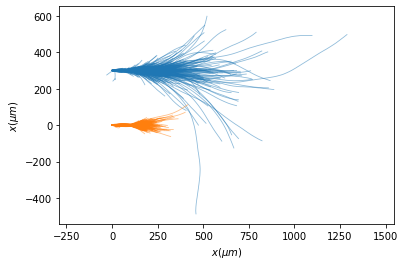

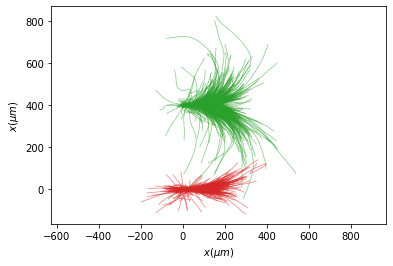

In [17]:
for x_ in X_fast1:
    plt.plot(x_[:,0],x_[:,1]+300,c=colors_state_[0],alpha=.5,lw=.8)
for x_ in X_fast2:
    plt.plot(x_[:,0],x_[:,1],c=colors_state_[1],alpha=.5,lw=.8)
plt.axis('equal')
plt.xlabel('$x(\mu m)$')
plt.ylabel('$x(\mu m)$')
# plt.savefig('fast_trajs.pdf')
plt.show()
for x_ in X_slow1:
    plt.plot(x_[:,0],x_[:,1]+400,c=colors_state_[2],alpha=.5,lw=.8)
for x_ in X_slow2:
    plt.plot(x_[:,0],x_[:,1],c=colors_state_[3],alpha=.5,lw=.8)
plt.axis('equal')
plt.xlabel('$x(\mu m)$')
plt.ylabel('$x(\mu m)$')
# plt.savefig('slow_trajs.pdf')
plt.show()


#  Posture characterization

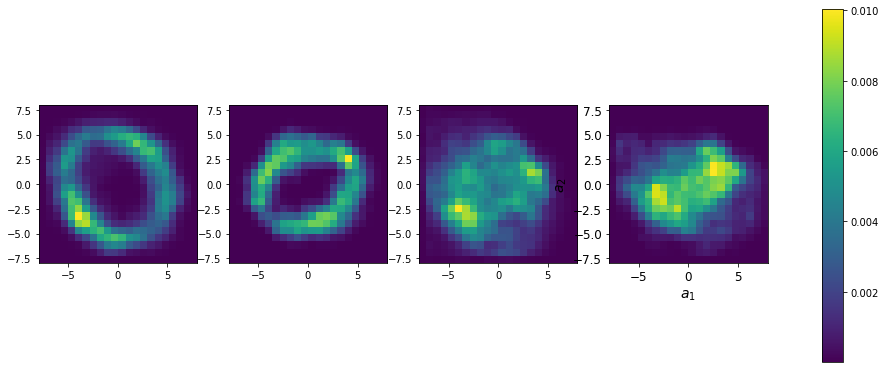

In [18]:
xrange = [-8,8]
yrange = [-8,8]
r=1
n_grid=20

x_range = np.linspace(xrange[0],xrange[1],n_grid+2*r)
y_range = np.linspace(yrange[0],yrange[1],n_grid+2*r)

fig, axes = plt.subplots(nrows=1, ncols=4,figsize=(15,7))
idx=1
for ax in axes.flat:
    x = ma.vstack(tseries_w)[cluster_traj==idx,0].compressed()
    y = ma.vstack(tseries_w)[cluster_traj==idx,1].compressed()
    density=stats.density_plot(x,y
                         ,xrange,yrange,n_grid,n_grid,border=r,smooth=False)
    data=density/density.sum()
    im = ax.imshow(data,origin = 'lower',extent = [xrange[0],xrange[1],yrange[0],yrange[1]],vmin=1e-5,vmax=data.max())
    plt.xlabel('$a_1$',fontsize=14)
    plt.ylabel('$a_2$',fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    idx+=1
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax)
# plt.tight_layout()
# plt.savefig('a1_a2_run_states.pdf')
plt.show()

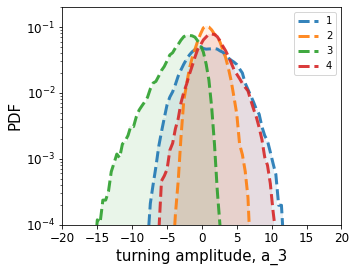

In [19]:
from scipy.stats import gaussian_kde
def histogram(array,bins,range_):
    freqs,bin_edges = np.histogram(array,bins=bins,range=range_)
    bins = np.array([np.mean([bin_edges[k],bin_edges[k+1]]) for k in range(len(bin_edges)-1)])
    binsize = np.diff(bin_edges)[0]
#     plt.bar(bins,freqs/freqs.sum(),binsize,alpha=alpha,label=label)
    return bins,freqs/freqs.sum(),binsize

n_bins=100
plt.figure(figsize=(5,4))

for idx in range(1,5):
    data= ma.vstack(tseries_w)[cluster_traj==idx,2].compressed()
#     kernel = gaussian_kde(data,bw_method=.2)
#     xvalues = np.linspace(-20,20,n_bins)
#     Z = kernel(xvalues)
    # plt.plot(xvalues,Z/Z.sum(),lw=5,ls='--')
    bins,prob,binsize = histogram(data,bins=n_bins,range_=[-20,20])
    plt.plot(bins,prob,alpha=.9,lw=3,ls='--',label=idx)
    plt.bar(bins,prob,binsize,alpha=.1,bottom=1e-5)

plt.legend()
plt.ylabel('PDF',fontsize=15)
plt.xlabel('turning amplitude, a_3',fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(1e-4,2e-1)
plt.yscale('log')
plt.xlim(-20,20)
# plt.savefig('a3_dist_run_states.pdf')
plt.show()

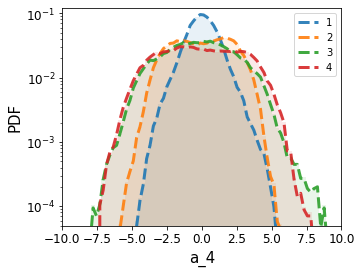

In [20]:
from scipy.stats import gaussian_kde
def histogram(array,bins,range_):
    freqs,bin_edges = np.histogram(array,bins=bins,range=range_)
    bins = np.array([np.mean([bin_edges[k],bin_edges[k+1]]) for k in range(len(bin_edges)-1)])
    binsize = np.diff(bin_edges)[0]
#     plt.bar(bins,freqs/freqs.sum(),binsize,alpha=alpha,label=label)
    return bins,freqs/freqs.sum(),binsize

n_bins=100
plt.figure(figsize=(5,4))

for idx in range(1,5):
    data= ma.vstack(tseries_w)[cluster_traj==idx,3].compressed()
#     kernel = gaussian_kde(data,bw_method=.2)
#     xvalues = np.linspace(-12,12,n_bins)
#     Z = kernel(xvalues)
    # plt.plot(xvalues,Z/Z.sum(),lw=5,ls='--')
    bins,prob,binsize = histogram(data,bins=n_bins,range_=[-12,12])
    plt.plot(bins,prob,alpha=.9,lw=3,ls='--',label=idx)
    plt.bar(bins,prob,binsize,alpha=.1,bottom=1e-5)

plt.legend()
plt.ylabel('PDF',fontsize=15)
plt.xlabel('a_4',fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(5e-5,1.2e-1)
plt.yscale('log')
plt.xlim(-10,10)
# plt.savefig('a4_dist_run_states.pdf')
plt.show()

# Kymographs

In [21]:

def calculate_skeleton(theta,worm_length = 1):
    """
    Calculates (x,y) coordinates of the worm centerline from the tangent angle (theta) vector

    :param theta: centerline angles
    :param worm_length: desired worm length
    """
    num_centerline_joints = len(theta)

    out = np.empty((num_centerline_joints, 2))

    centerline_section_length = worm_length / (num_centerline_joints - 1)
    np.cumsum(
        [
            centerline_section_length * np.cos(theta),
            centerline_section_length * np.sin(theta),
        ],
        axis=1,
        out=out.T,
    )
    return out

In [8]:
eigenworms_matrix = np.loadtxt(dir_path+'Foraging/ForagingData/EigenWorms.csv', delimiter=',').astype(np.float32)
thetas_w = ma.array([ts.dot(eigenworms_matrix[:,:5].T) for ts in tseries_w])
thetas_all = ma.vstack(thetas_w)

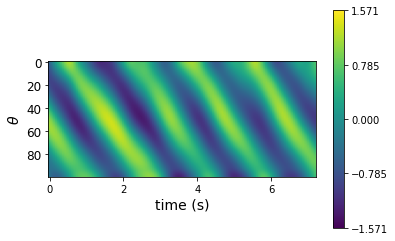

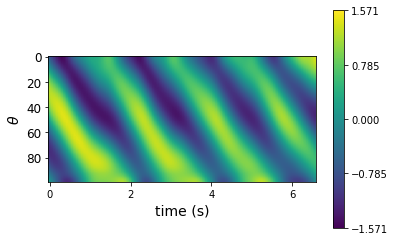

<Figure size 432x288 with 0 Axes>

In [23]:
mask = cluster_traj==1
segments = np.where(np.abs(np.diff(np.concatenate([[False], mask, [False]]))))[0].reshape(-1, 2)
indices = np.argsort(np.hstack(np.diff(segments,axis=1)))[::-1]
for idx in range(2):
    t0,tf = segments[indices[idx]]
    t_0 = (int(np.ceil(t0/len_w))-1)*len_w
    plt.imshow(thetas_all[t0:tf].T,aspect=.5,vmax=np.pi/2,vmin=-np.pi/2)
    plt.xticks(np.arange(0,tf-t0,2*frameRate),np.array(np.arange(0,(tf-t0)*dt,2),dtype=int))
    plt.ylabel(r'$\theta$',fontsize=14)
    plt.xlabel('time (s)',fontsize=14)
#     plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.colorbar(ticks=[-np.pi/2,-np.pi/4,0,np.pi/4,np.pi/2])
#     plt.savefig('theta_fast1_{}.pdf'.format(idx))
    plt.show()
    plt.clf()

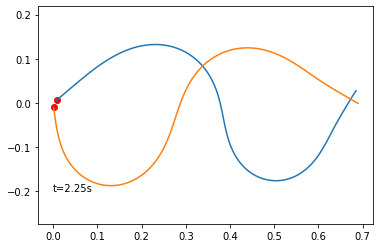

In [24]:
mask = cluster_traj==1
segments = np.where(np.abs(np.diff(np.concatenate([[False], mask, [False]]))))[0].reshape(-1, 2)
indices = np.argsort(np.hstack(np.diff(segments,axis=1)))[::-1]
t0,tf = segments[indices[idx]]
t_0 = (int(np.ceil(t0/len_w))-1)*len_w
kt=int(1.5*frameRate)
skel = calculate_skeleton(thetas_all[t0+kt].T)
plt.plot(skel[:,0],skel[:,1])
plt.scatter(skel[0,0],skel[0,1],c='r')
kt=int(2.25*frameRate)
skel = calculate_skeleton(thetas_all[t0+kt].T)
plt.plot(skel[:,0],skel[:,1])
plt.scatter(skel[0,0],skel[0,1],c='r')
plt.axis('equal')
plt.text(0.0,-.2,'t=2.25s')
# plt.savefig('example_posture_fast1_2.pdf')
plt.show()

In [25]:
indices[idx]

8773

54


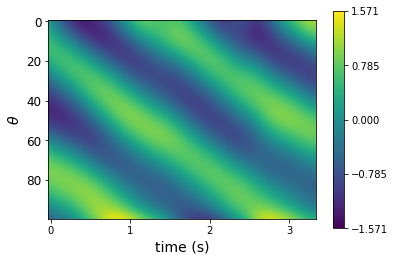

46


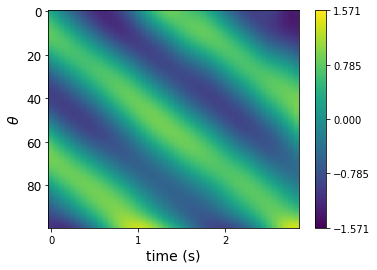

<Figure size 432x288 with 0 Axes>

In [26]:
mask = cluster_traj==2
segments = np.where(np.abs(np.diff(np.concatenate([[False], mask, [False]]))))[0].reshape(-1, 2)
indices = np.argsort(np.hstack(np.diff(segments,axis=1)))[::-1]
for idx in range(2):
    t0,tf = segments[indices[idx]]
    print(tf-t0)
    t_0 = (int(np.ceil(t0/len_w))-1)*len_w
    plt.imshow(thetas_all[t0:tf].T,aspect=.4,vmax=np.pi/2,vmin=-np.pi/2)
    plt.xticks(np.arange(0,tf-t0,1*frameRate),np.array(np.arange(0,(tf-t0)*dt,1),dtype=int))
    plt.ylabel(r'$\theta$',fontsize=14)
    plt.xlabel('time (s)',fontsize=14)
#     plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.colorbar(ticks=[-np.pi/2,-np.pi/4,0,np.pi/4,np.pi/2])
#     plt.savefig('theta_fast2_{}.pdf'.format(idx))
    plt.show()
    plt.clf()

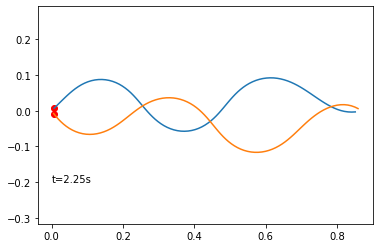

In [27]:
mask = cluster_traj==2
segments = np.where(np.abs(np.diff(np.concatenate([[False], mask, [False]]))))[0].reshape(-1, 2)
indices = np.argsort(np.hstack(np.diff(segments,axis=1)))[::-1]
t0,tf = segments[indices[idx]]
t_0 = (int(np.ceil(t0/len_w))-1)*len_w
kt=int(1.5*frameRate)
skel = calculate_skeleton(thetas_all[t0+kt].T)
plt.plot(skel[:,0],skel[:,1])
plt.scatter(skel[0,0],skel[0,1],c='r')
kt=int(2.25*frameRate)
skel = calculate_skeleton(thetas_all[t0+kt].T)
plt.plot(skel[:,0],skel[:,1])
plt.scatter(skel[0,0],skel[0,1],c='r')
plt.axis('equal')
plt.text(0.0,-.2,'t=2.25s')
# plt.savefig('example_posture_fast2_2.pdf')
plt.show()

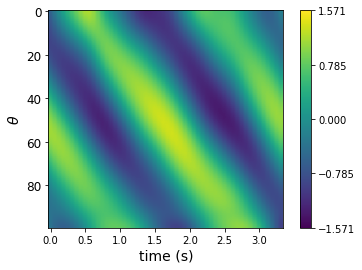

<Figure size 432x288 with 0 Axes>

In [28]:
mask = cluster_traj==1
segments = np.where(np.abs(np.diff(np.concatenate([[False], mask, [False]]))))[0].reshape(-1, 2)
indices = np.argsort(np.hstack(np.diff(segments,axis=1)))[::-1]
idx=0
t0,tf = segments[indices[idx]]
tf = t0+54
t_0 = (int(np.ceil(t0/len_w))-1)*len_w
plt.imshow(thetas_all[t0:tf].T,aspect=.5,vmax=np.pi/2,vmin=-np.pi/2)
plt.xticks(np.arange(0,tf-t0,0.5*frameRate),np.array(np.arange(0,(tf-t0)*dt,.5),dtype=float))
plt.ylabel(r'$\theta$',fontsize=14)
plt.xlabel('time (s)',fontsize=14)
#     plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.colorbar(ticks=[-np.pi/2,-np.pi/4,0,np.pi/4,np.pi/2])
# plt.savefig('theta_fast1_sametime.pdf')
plt.show()
plt.clf()

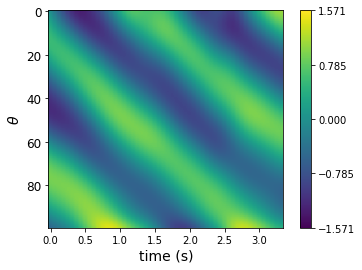

<Figure size 432x288 with 0 Axes>

In [29]:
mask = cluster_traj==2
segments = np.where(np.abs(np.diff(np.concatenate([[False], mask, [False]]))))[0].reshape(-1, 2)
indices = np.argsort(np.hstack(np.diff(segments,axis=1)))[::-1]
idx=0
t0,tf = segments[indices[idx]]
tf = t0+54
t_0 = (int(np.ceil(t0/len_w))-1)*len_w
plt.imshow(thetas_all[t0:tf].T,aspect=.5,vmax=np.pi/2,vmin=-np.pi/2)
plt.xticks(np.arange(0,tf-t0,0.5*frameRate),np.array(np.arange(0,(tf-t0)*dt,.5),dtype=float))
plt.ylabel(r'$\theta$',fontsize=14)
plt.xlabel('time (s)',fontsize=14)
#     plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.colorbar(ticks=[-np.pi/2,-np.pi/4,0,np.pi/4,np.pi/2])
# plt.savefig('theta_fast2_sametime.pdf')
plt.show()
plt.clf()

In [30]:
from scipy.signal import welch
mask = cluster_traj==1
segments = np.where(np.abs(np.diff(np.concatenate([[False], mask, [False]]))))[0].reshape(-1, 2)
indices = np.argsort(np.hstack(np.diff(segments,axis=1)))[::-1]
max_freq_seg1 = []
for t0,tf in segments:
# t0,tf = segments[1]
    max_freq = []
    for t in range(t0,tf):
        x= thetas_all[t]
        fs=1
        f, Pxx_den = welch(x, fs, nperseg=99,nfft=5000,scaling='spectrum')
        max_freq.append(f[np.argmax(Pxx_den)])
    max_freq_seg1.append(max_freq)
    
mask = cluster_traj==2
segments = np.where(np.abs(np.diff(np.concatenate([[False], mask, [False]]))))[0].reshape(-1, 2)
indices = np.argsort(np.hstack(np.diff(segments,axis=1)))[::-1]
max_freq_seg2 = []
for t0,tf in segments:
# t0,tf = segments[1]
    max_freq = []
    for t in range(t0,tf):
        x= thetas_all[t]
        fs=1
        f, Pxx_den = welch(x, fs, nperseg=99,nfft=5000,scaling='spectrum')
        max_freq.append(f[np.argmax(Pxx_den)])
    max_freq_seg2.append(max_freq)

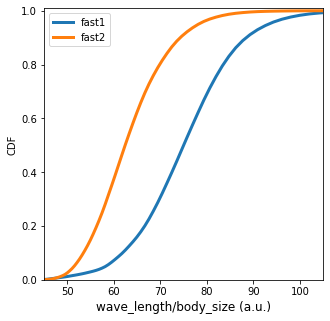

In [31]:
plt.figure(figsize=(5,5))
x,y = stats.cumulative_dist(1/np.hstack(max_freq_seg1),lims=(0,120))
y = np.array([np.mean(y[x==x_unique]) for x_unique in np.unique(x)])
x = np.sort(np.unique(x))
plt.plot(x,y,c=colors_state_[0],label='fast1',lw=3)

x,y = stats.cumulative_dist(1/np.hstack(max_freq_seg2),lims=(0,120))
y = np.array([np.mean(y[x==x_unique]) for x_unique in np.unique(x)])
x = np.sort(np.unique(x))
plt.plot(x,y,c=colors_state_[1],label='fast2',lw=3)
plt.xlabel('wave_length/body_size (a.u.)',fontsize=12)
plt.ylabel('CDF')
plt.xlim(45,105)
plt.ylim(0,1.01)
plt.legend()
# plt.savefig('wave_length_fast_states.pdf')
plt.show()

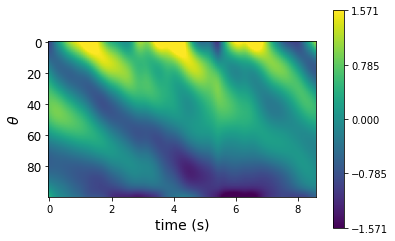

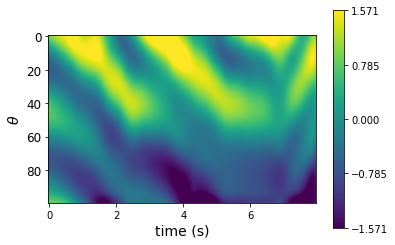

<Figure size 432x288 with 0 Axes>

In [32]:
mask = cluster_traj==3
segments = np.where(np.abs(np.diff(np.concatenate([[False], mask, [False]]))))[0].reshape(-1, 2)
indices = np.argsort(np.hstack(np.diff(segments,axis=1)))[::-1]
for idx in range(2):
    t0,tf = segments[indices[idx]]
    t_0 = (int(np.ceil(t0/len_w))-1)*len_w
    plt.imshow(thetas_all[t0:tf].T,aspect=.8,vmax=np.pi/2,vmin=-np.pi/2)
    plt.xticks(np.arange(0,tf-t0,2*frameRate),np.array(np.arange(0,(tf-t0)*dt,2),dtype=int))
    plt.ylabel(r'$\theta$',fontsize=14)
    plt.xlabel('time (s)',fontsize=14)
#     plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.colorbar(ticks=[-np.pi/2,-np.pi/4,0,np.pi/4,np.pi/2])
#     plt.savefig('theta_slow1_{}.pdf'.format(idx))
    plt.show()
    plt.clf()

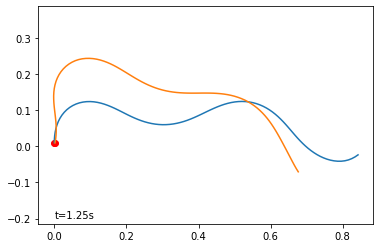

In [33]:
mask = cluster_traj==3
segments = np.where(np.abs(np.diff(np.concatenate([[False], mask, [False]]))))[0].reshape(-1, 2)
indices = np.argsort(np.hstack(np.diff(segments,axis=1)))[::-1]
t0,tf = segments[indices[idx]]
t_0 = (int(np.ceil(t0/len_w))-1)*len_w
kt=int(.5*frameRate)
skel = calculate_skeleton(thetas_all[t0+kt].T)
plt.plot(skel[:,0],skel[:,1])
plt.scatter(skel[0,0],skel[0,1],c='r')
kt=int(1.25*frameRate)
skel = calculate_skeleton(thetas_all[t0+kt].T)
plt.plot(skel[:,0],skel[:,1])
plt.scatter(skel[0,0],skel[0,1],c='r')
plt.axis('equal')
plt.text(0.0,-.2,'t=1.25s')
# plt.savefig('example_posture_slow1_1.pdf')
plt.show()

133


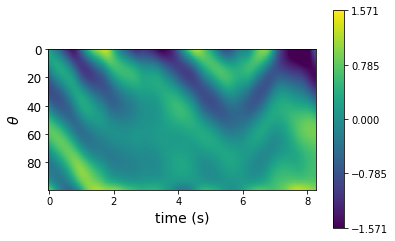

120


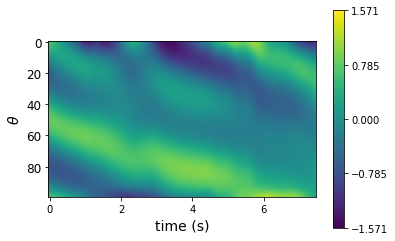

<Figure size 432x288 with 0 Axes>

In [34]:
mask = cluster_traj==4
segments = np.where(np.abs(np.diff(np.concatenate([[False], mask, [False]]))))[0].reshape(-1, 2)
indices = np.argsort(np.hstack(np.diff(segments,axis=1)))[::-1]
for idx in range(2):
    t0,tf = segments[indices[idx]]
    print(tf-t0)
    t_0 = (int(np.ceil(t0/len_w))-1)*len_w
    plt.imshow(thetas_all[t0:tf].T,aspect=.7,vmax=np.pi/2,vmin=-np.pi/2)
    plt.xticks(np.arange(0,tf-t0,2*frameRate),np.array(np.arange(0,(tf-t0)*dt,2),dtype=int))
    plt.ylabel(r'$\theta$',fontsize=14)
    plt.xlabel('time (s)',fontsize=14)
    plt.yticks(fontsize=12)
    plt.colorbar(ticks=[-np.pi/2,-np.pi/4,0,np.pi/4,np.pi/2])
#     plt.savefig('theta_slow2_{}.pdf'.format(idx))
    plt.show()
    plt.clf()

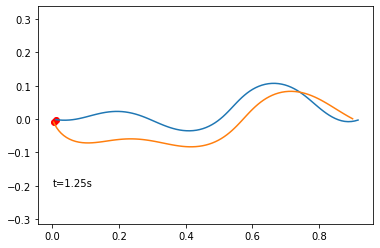

In [35]:
mask = cluster_traj==4
segments = np.where(np.abs(np.diff(np.concatenate([[False], mask, [False]]))))[0].reshape(-1, 2)
indices = np.argsort(np.hstack(np.diff(segments,axis=1)))[::-1]
t0,tf = segments[indices[idx]]
t_0 = (int(np.ceil(t0/len_w))-1)*len_w
kt=int(.5*frameRate)
skel = calculate_skeleton(thetas_all[t0+kt].T)
plt.plot(skel[:,0],skel[:,1])
plt.scatter(skel[0,0],skel[0,1],c='r')
kt=int(1.25*frameRate)
skel = calculate_skeleton(thetas_all[t0+kt].T)
plt.plot(skel[:,0],skel[:,1])
plt.scatter(skel[0,0],skel[0,1],c='r')
plt.axis('equal')
plt.text(0.0,-.2,'t=1.25s')
# plt.savefig('example_posture_slow2_1.pdf')
plt.show()

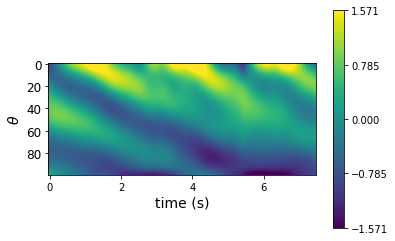

<Figure size 432x288 with 0 Axes>

In [36]:
mask = cluster_traj==3
segments = np.where(np.abs(np.diff(np.concatenate([[False], mask, [False]]))))[0].reshape(-1, 2)
indices = np.argsort(np.hstack(np.diff(segments,axis=1)))[::-1]
idx=0
t0,tf = segments[indices[idx]]
tf = t0+120
t_0 = (int(np.ceil(t0/len_w))-1)*len_w
plt.imshow(thetas_all[t0:tf].T,aspect=.5,vmax=np.pi/2,vmin=-np.pi/2)
plt.xticks(np.arange(0,tf-t0,2*frameRate),np.array(np.arange(0,(tf-t0)*dt,2),dtype=int))
plt.ylabel(r'$\theta$',fontsize=14)
plt.xlabel('time (s)',fontsize=14)
#     plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.colorbar(ticks=[-np.pi/2,-np.pi/4,0,np.pi/4,np.pi/2])
# plt.savefig('theta_slow1_sametime.pdf')
plt.show()
plt.clf()

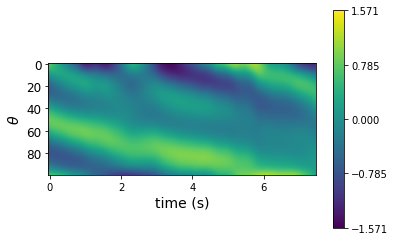

<Figure size 432x288 with 0 Axes>

In [37]:
mask = cluster_traj==4
segments = np.where(np.abs(np.diff(np.concatenate([[False], mask, [False]]))))[0].reshape(-1, 2)
indices = np.argsort(np.hstack(np.diff(segments,axis=1)))[::-1]
idx=1
t0,tf = segments[indices[idx]]
tf = t0+120
t_0 = (int(np.ceil(t0/len_w))-1)*len_w
plt.imshow(thetas_all[t0:tf].T,aspect=.5,vmax=np.pi/2,vmin=-np.pi/2)
plt.xticks(np.arange(0,tf-t0,2*frameRate),np.array(np.arange(0,(tf-t0)*dt,2),dtype=int))
plt.ylabel(r'$\theta$',fontsize=14)
plt.xlabel('time (s)',fontsize=14)
#     plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.colorbar(ticks=[-np.pi/2,-np.pi/4,0,np.pi/4,np.pi/2])
# plt.savefig('theta_slow2_sametime.pdf')
plt.show()
plt.clf()